In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras

In [2]:
DOWNLOAD_ROOT = 'http://download.tensorflow.org/data/'
FILENAME = 'quickdraw_tutorial_dataset_v1.tar.gz'
filepath = keras.utils.get_file(FILENAME, 
                                DOWNLOAD_ROOT + FILENAME, 
                                cache_subdir='datasets/quickdraw', 
                                extract=True)

In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob('training.tfrecord-*')])
eval_files = sorted([str(path) for path in quickdraw_dir.glob('eval.tfrecord-*')])

In [4]:
with open(quickdraw_dir / 'eval.tfrecord.classes') as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / 'training.tfrecord.classes') as train_classes_file:
    train_classes = train_classes_file.readlines()

In [5]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [6]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [7]:
def parse(data_batch):
    feature_descriptions = {
        'ink': tf.io.VarLenFeature(dtype=tf.float32),
        'shape': tf.io.FixedLenFeature([2], dtype=tf.int64),
        'class_index': tf.io.FixedLenFeature([1], dtype=tf.int64),
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples['ink'])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples['shape'][:, 0]
    labels = examples['class_index'][:, 0]
    return sketches, lengths, labels

In [8]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None, 
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths, 
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [9]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [10]:
for sketches, lengths, labels in train_set.take(1):
    print(f'sketches = {sketches}')
    print(f'lengths = {lengths}')
    print(f'labels = {labels}')

sketches = [[[ 0.04861112 -0.09842521  0.        ]
  [ 0.         -0.1574803   0.        ]
  [-0.21527778 -0.35826772  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.05905509  0.01176471  0.        ]
  [-0.00393701 -0.02941173  0.        ]
  [ 0.02755904 -0.02941179  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.02352941  0.00847459  0.        ]
  [-0.01176471  0.03389829  0.        ]
  [-0.01960784  0.16101694  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.38823533 -0.3425197   0.        ]
  [-0.12156863 -0.12992126  0.        ]
  [-0.10980392 -0.14173229  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.   

In [11]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1] == 1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else 'Try to guess'
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], 'y:')
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], '.-')
    plt.axis('off')
    
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

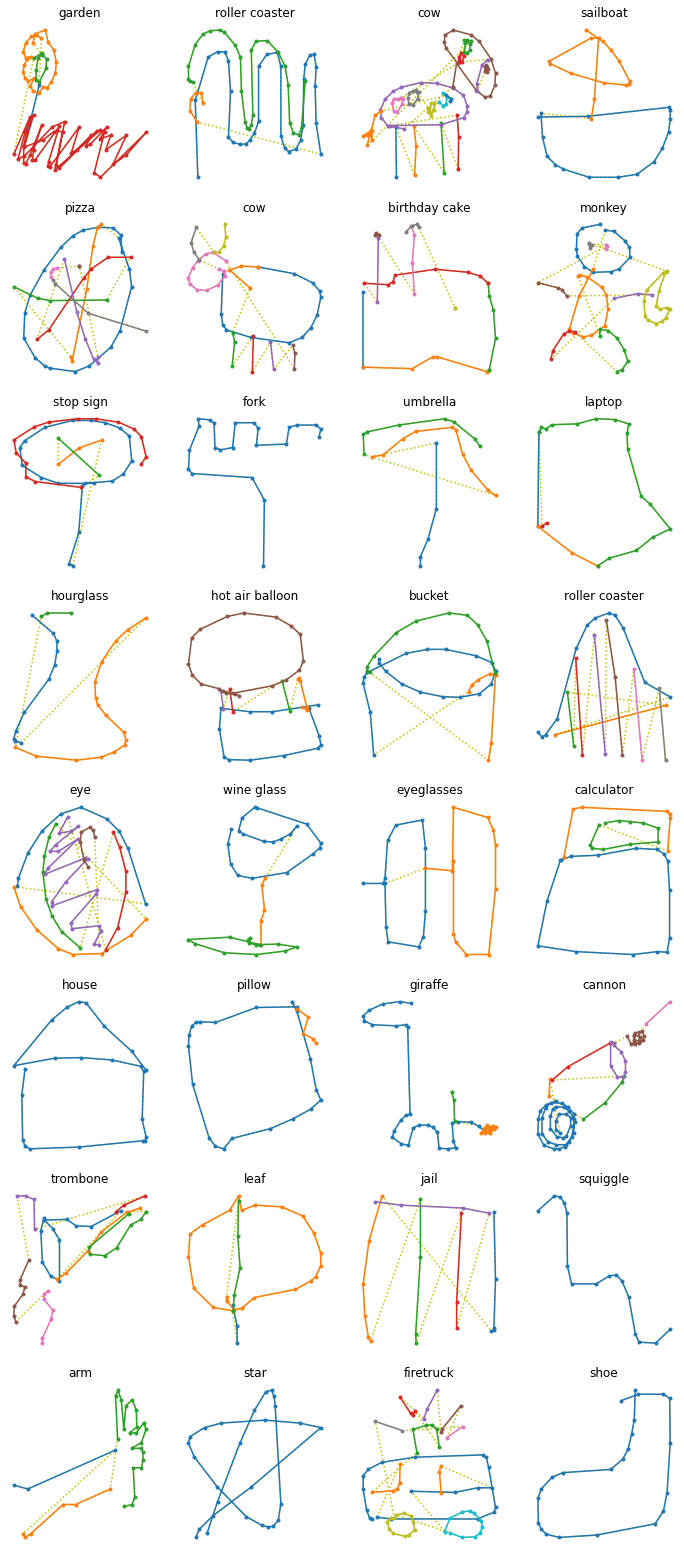

In [12]:
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

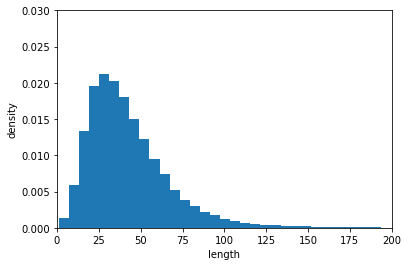

In [13]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel('length')
plt.ylabel('density')
plt.show()

In [14]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

In [15]:
cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
croped_test_set = crop_long_sketches(test_set)

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(len(class_names), activation='softmax')
])

optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['acc', 'sparse_top_k_categorical_accuracy'])

In [17]:
history = model.fit(cropped_train_set, epochs=3, 
                    validation_data=cropped_valid_set)

Epoch 1/3
107813/107813 [==============================] - 1483s 14ms/step - loss: 4.2029 - acc: 0.1515 - sparse_top_k_categorical_accuracy: 0.3466 - val_loss: 3.1704 - val_acc: 0.2984 - val_sparse_top_k_categorical_accuracy: 0.5778
Epoch 2/3
107813/107813 [==============================] - 1477s 14ms/step - loss: 2.7555 - acc: 0.3728 - sparse_top_k_categorical_accuracy: 0.6597 - val_loss: 2.4365 - val_acc: 0.4339 - val_sparse_top_k_categorical_accuracy: 0.7190
Epoch 3/3
107813/107813 [==============================] - 1480s 14ms/step - loss: 2.3056 - acc: 0.4575 - sparse_top_k_categorical_accuracy: 0.7418 - val_loss: 2.2092 - val_acc: 0.4748 - val_sparse_top_k_categorical_accuracy: 0.7591


In [18]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [19]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.65316933

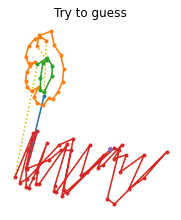

Top-5 predictions:
	1. camouflage 7.998%
	2. octopus 6.976%
	3. dragon 5.678%
	4. angel 5.228%
	5. animal migration 3.986%
Answer: garden


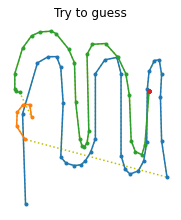

Top-5 predictions:
	1. roller coaster 39.705%
	2. toe 8.500%
	3. camel 8.198%
	4. squiggle 7.771%
	5. elephant 7.102%
Answer: roller coaster


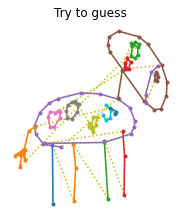

Top-5 predictions:
	1. cow 91.939%
	2. tiger 0.932%
	3. dog 0.924%
	4. pig 0.921%
	5. zebra 0.415%
Answer: cow


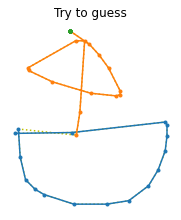

Top-5 predictions:
	1. sailboat 85.051%
	2. cruise ship 4.964%
	3. aircraft carrier 3.996%
	4. speedboat 1.264%
	5. bathtub 0.823%
Answer: sailboat


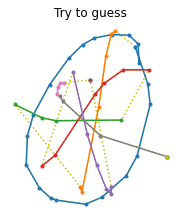

Top-5 predictions:
	1. basketball 30.736%
	2. wheel 27.553%
	3. pizza 15.666%
	4. soccer ball 14.875%
	5. baseball 2.611%
Answer: pizza


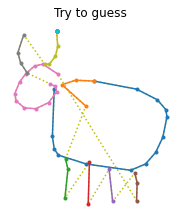

Top-5 predictions:
	1. cow 50.022%
	2. crab 13.328%
	3. dog 6.285%
	4. pig 3.655%
	5. rhinoceros 3.268%
Answer: cow


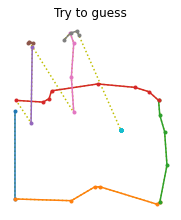

Top-5 predictions:
	1. birthday cake 32.271%
	2. cake 13.976%
	3. radio 11.073%
	4. bed 8.611%
	5. hot tub 3.362%
Answer: birthday cake


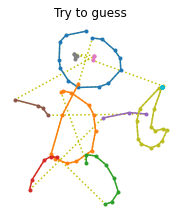

Top-5 predictions:
	1. ant 15.289%
	2. monkey 11.403%
	3. octopus 7.638%
	4. drums 4.980%
	5. frog 4.500%
Answer: monkey


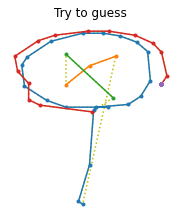

Top-5 predictions:
	1. tennis racquet 19.129%
	2. lollipop 15.353%
	3. mushroom 14.954%
	4. fan 7.918%
	5. microphone 6.266%
Answer: stop sign


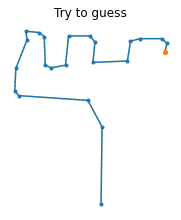

Top-5 predictions:
	1. fork 27.311%
	2. castle 16.002%
	3. hand 14.272%
	4. beach 5.658%
	5. camel 5.608%
Answer: fork


In [20]:
n_new = 10
y_probas = model.predict(sketches)
top_k = tf.nn.top_k(y_probas, k=5)

for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print('Top-5 predictions:'.format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print('\t{}. {} {:.3f}%'.format(k + 1, class_name, proba))
    print('Answer: {}'.format(class_names[labels[index].numpy()]))

In [21]:
model.save('sketch.h5')